In [1]:

# 5. Implementation id="implementation"
import math
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.datasets import load_digits
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Reproducibility (note: VAE remains stochastic by design)
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ----- Data -----
digits = load_digits()
X = digits.images.astype(np.float32) / 16.0  # original range 0..16
y = digits.target

X = X[:, None, :, :]  # (N,1,8,8) add channel dim
N = X.shape[0]

# Flatten utility
def flatten_img(x):
    return x.reshape(-1, 64)

# Stratified split 70/15/15
sss1 = StratifiedShuffleSplit(n_splits=1, test_size=0.30, random_state=seed)
train_idx, temp_idx = next(sss1.split(X, y))
X_train, y_train = X[train_idx], y[train_idx]
X_temp, y_temp = X[temp_idx], y[temp_idx]

sss2 = StratifiedShuffleSplit(n_splits=1, test_size=0.50, random_state=seed)
val_idx, test_idx = next(sss2.split(X_temp, y_temp))
X_val, y_val = X_temp[val_idx], y_temp[val_idx]
X_test, y_test = X_temp[test_idx], y_temp[test_idx]

# Torch datasets/loaders
def make_loader(X, batch_size=128, shuffle=True):
    t = torch.tensor(flatten_img(X), dtype=torch.float32)
    ds = TensorDataset(t)
    return DataLoader(ds, batch_size=batch_size, shuffle=shuffle)

train_loader = make_loader(X_train)
val_loader   = make_loader(X_val, shuffle=False)
test_loader  = make_loader(X_test, shuffle=False)

input_dim = 64
hidden_dim = 128
latent_dim = 8  # configurable
beta = 1.0      # β-VAE coefficient

# ----- Models -----
class AE(nn.Module):
    def __init__(self, input_dim=64, hidden_dim=128, latent_dim=8):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, latent_dim),
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
        )
    def forward(self, x):
        z = self.encoder(x)
        xhat = self.decoder(z)
        return xhat

class VAE(nn.Module):
    def __init__(self, input_dim=64, hidden_dim=128, latent_dim=8):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        self.fc3 = nn.Linear(latent_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, input_dim)
    def encode(self, x):
        h = F.relu(self.fc1(x))
        return self.fc_mu(h), self.fc_logvar(h)
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        xhat = self.decode(z)
        return xhat, mu, logvar

# Losses
mse_loss = nn.MSELoss(reduction='mean')

def vae_loss(x, xhat, mu, logvar, beta=1.0):
    recon = mse_loss(xhat, x)
    # KL divergence term for diagonal Gaussian
    kld = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    return recon + beta * kld, recon.detach(), kld.detach()

# Early stopping
class EarlyStopper:
    def __init__(self, patience=20, min_delta=1e-5):
        self.patience = patience
        self.min_delta = min_delta
        self.best = float('inf')
        self.count = 0
    def step(self, val):
        if val < self.best - self.min_delta:
            self.best = val
            self.count = 0
            return False  # not stopping
        else:
            self.count += 1
            return self.count >= self.patience

# Training utilities
def train_autoencoder(model, train_loader, val_loader, epochs=200, lr=1e-3):
    model = model.to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    stopper = EarlyStopper(patience=20, min_delta=1e-5)
    hist = {'train_loss': [], 'val_loss': []}
    best_state = None
    best_val = float('inf')
    for ep in range(1, epochs+1):
        model.train()
        tl = 0.0
        for (xb,) in train_loader:
            xb = xb.to(device)
            xhat = model(xb)
            loss = mse_loss(xhat, xb)
            opt.zero_grad()
            loss.backward()
            opt.step()
            tl += loss.item() * xb.size(0)
        tl /= len(train_loader.dataset)
        # val
        model.eval()
        vl = 0.0
        with torch.no_grad():
            for (xb,) in val_loader:
                xb = xb.to(device)
                xhat = model(xb)
                loss = mse_loss(xhat, xb)
                vl += loss.item() * xb.size(0)
        vl /= len(val_loader.dataset)
        hist['train_loss'].append(tl)
        hist['val_loss'].append(vl)
        if vl < best_val:
            best_val = vl
            best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
        if stopper.step(vl):
            break
    if best_state is not None:
        model.load_state_dict(best_state)
    return model, hist

def train_vae(model, train_loader, val_loader, epochs=200, lr=1e-3, beta=1.0):
    model = model.to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    stopper = EarlyStopper(patience=20, min_delta=1e-5)
    hist = {'train_total': [], 'train_recon': [], 'train_kl': [],
            'val_total': [], 'val_recon': [], 'val_kl': []}
    best_state = None
    best_val = float('inf')
    for ep in range(1, epochs+1):
        model.train()
        tt = tr = tk = 0.0
        for (xb,) in train_loader:
            xb = xb.to(device)
            xhat, mu, logvar = model(xb)
            loss, recon, kld = vae_loss(xb, xhat, mu, logvar, beta=beta)
            opt.zero_grad()
            loss.backward()
            opt.step()
            bs = xb.size(0)
            tt += loss.item() * bs
            tr += recon.item() * bs
            tk += kld.item() * bs
        Ntr = len(train_loader.dataset)
        tt /= Ntr; tr /= Ntr; tk /= Ntr

        # val
        model.eval()
        vt = vr = vk = 0.0
        with torch.no_grad():
            for (xb,) in val_loader:
                xb = xb.to(device)
                xhat, mu, logvar = model(xb)
                loss, recon, kld = vae_loss(xb, xhat, mu, logvar, beta=beta)
                bs = xb.size(0)
                vt += loss.item() * bs
                vr += recon.item() * bs
                vk += kld.item() * bs
        Nval = len(val_loader.dataset)
        vt /= Nval; vr /= Nval; vk /= Nval

        hist['train_total'].append(tt); hist['train_recon'].append(tr); hist['train_kl'].append(tk)
        hist['val_total'].append(vt);   hist['val_recon'].append(vr);   hist['val_kl'].append(vk)

        if vt < best_val:
            best_val = vt
            best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
        if stopper.step(vt):
            break
    if best_state is not None:
        model.load_state_dict(best_state)
    return model, hist

# Helper: simple Frechet distance in pixel space (Gaussian assumption)
def frechet_distance(mu1, C1, mu2, C2, eps=1e-6):
    # Fréchet distance between two Gaussians N(mu1, C1) and N(mu2, C2)
    diff = mu1 - mu2
    # sqrtm of product (numerical stabilizer via eigen-decomp)
    vals1, vecs1 = np.linalg.eigh(C1 + eps*np.eye(C1.shape[0]))
    vals2, vecs2 = np.linalg.eigh(C2 + eps*np.eye(C2.shape[0]))
    S1 = (vecs1 * np.sqrt(np.clip(vals1, 0, None))) @ vecs1.T
    S2 = (vecs2 * np.sqrt(np.clip(vals2, 0, None))) @ vecs2.T
    prod = S1 @ S2
    valsP, _ = np.linalg.eigh(prod @ prod.T)
    tr_sqrt = np.sum(np.sqrt(np.clip(valsP, 0, None)))
    return diff.dot(diff) + np.trace(C1 + C2 - 2 * tr_sqrt * np.eye(C1.shape[0]))

def gaussian_stats(images):
    # images: (N,64) in [0,1]
    mu = images.mean(axis=0)
    C = np.cov(images.T)
    return mu, C


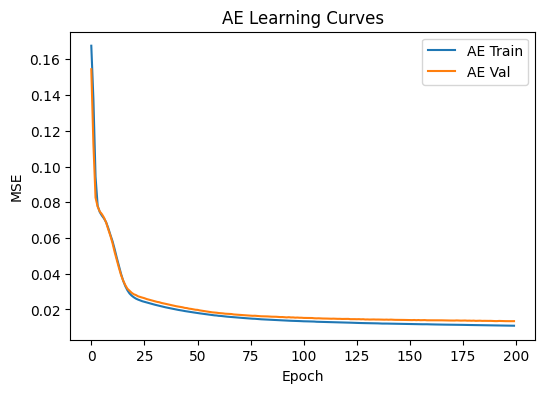

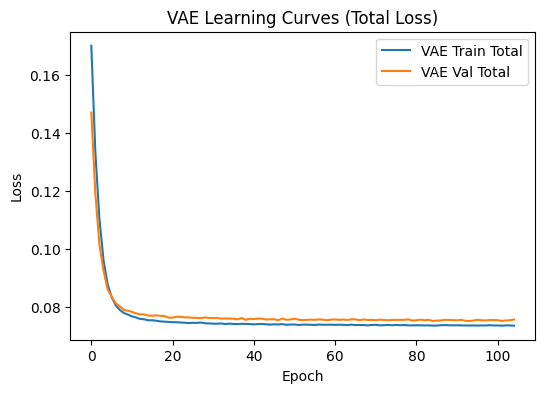

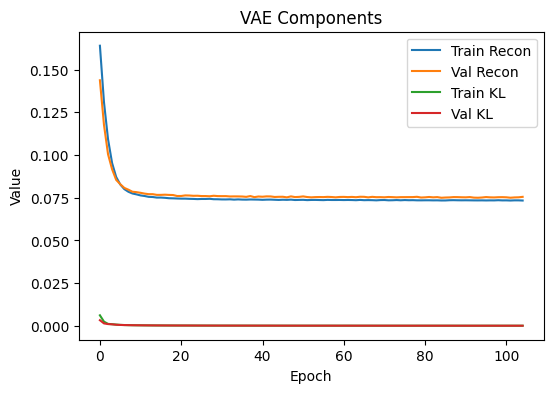

In [2]:

# 6. Training <a id="training"></a>

ae = AE(input_dim=input_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)
vae = VAE(input_dim=input_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)

ae, ae_hist = train_autoencoder(ae, train_loader, val_loader, epochs=200, lr=1e-3)
vae, vae_hist = train_vae(vae, train_loader, val_loader, epochs=200, lr=1e-3, beta=beta)

# Plot learning curves
plt.figure(figsize=(6,4))
plt.plot(ae_hist['train_loss'], label='AE Train')
plt.plot(ae_hist['val_loss'], label='AE Val')
plt.title('AE Learning Curves')
plt.xlabel('Epoch'); plt.ylabel('MSE'); plt.legend(); plt.show()

plt.figure(figsize=(6,4))
plt.plot(vae_hist['train_total'], label='VAE Train Total')
plt.plot(vae_hist['val_total'], label='VAE Val Total')
plt.title('VAE Learning Curves (Total Loss)')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.show()

plt.figure(figsize=(6,4))
plt.plot(vae_hist['train_recon'], label='Train Recon')
plt.plot(vae_hist['val_recon'], label='Val Recon')
plt.plot(vae_hist['train_kl'], label='Train KL')
plt.plot(vae_hist['val_kl'], label='Val KL')
plt.title('VAE Components')
plt.xlabel('Epoch'); plt.ylabel('Value'); plt.legend(); plt.show()


In [3]:

# 7. Evaluation & Results <a id="evaluation"></a>

def evaluate_recon_mse(model, loader, stochastic=False, T=10):
    model.eval()
    mses = []
    with torch.no_grad():
        for (xb,) in loader:
            xb = xb.to(device)
            if stochastic:
                # average over T stochastic decodes for VAE
                xhats = []
                for _ in range(T):
                    xhat, mu, logvar = model(xb)
                    xhats.append(xhat.unsqueeze(0))
                xhats = torch.cat(xhats, dim=0).mean(0)
            else:
                xhat = model(xb) if isinstance(model, AE) else model(xb)[0]
                xhats = xhat
            mses.append(F.mse_loss(xhats, xb, reduction='none').mean(dim=1).cpu().numpy())
    return float(np.mean(np.concatenate(mses)))

ae_test_mse = evaluate_recon_mse(ae, test_loader, stochastic=False)
vae_test_mse_single = evaluate_recon_mse(vae, test_loader, stochastic=False)
vae_test_mse_multi  = evaluate_recon_mse(vae, test_loader, stochastic=True, T=10)

print(f"AE   Test MSE: {ae_test_mse:.6f}")
print(f"VAE  Test MSE (single sample): {vae_test_mse_single:.6f}")
print(f"VAE  Test MSE (mean over 10 samples): {vae_test_mse_multi:.6f}")

# Simple Fréchet-like distance in pixel space (proxy for FID)
# Compare distribution of real test images vs generated samples from prior z~N(0,I)
vae = vae.to(device)
vae.eval()
with torch.no_grad():
    # Real stats
    Xtest = torch.tensor(flatten_img(X_test), dtype=torch.float32).numpy()
    mu_r, C_r = gaussian_stats(Xtest)

    # Generate samples
    n_gen = X_test.shape[0]
    z = torch.randn(n_gen, latent_dim, device=device)
    Xgen = vae.decode(z).cpu().numpy()
    mu_g, C_g = gaussian_stats(Xgen)

fd = frechet_distance(mu_r, C_r, mu_g, C_g)
print(f"Fréchet-like Distance (pixel space, lower is better): {fd:.4f}")


AE   Test MSE: 0.012615
VAE  Test MSE (single sample): 0.072904
VAE  Test MSE (mean over 10 samples): 0.072630
Fréchet-like Distance (pixel space, lower is better): -19.6716


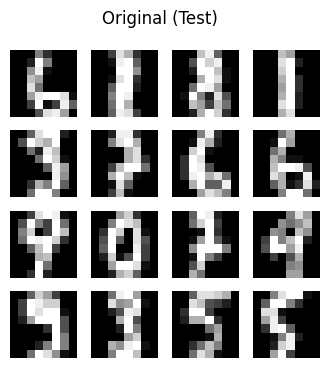

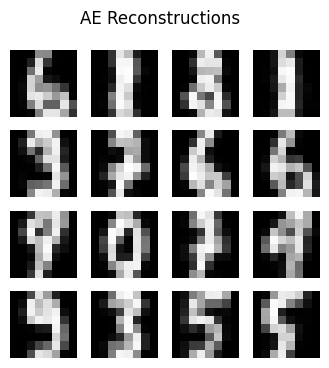

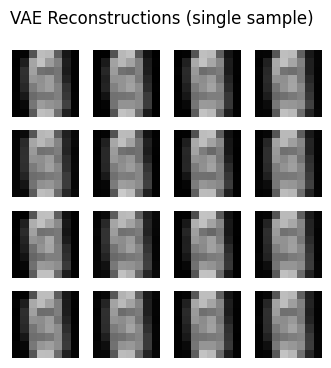

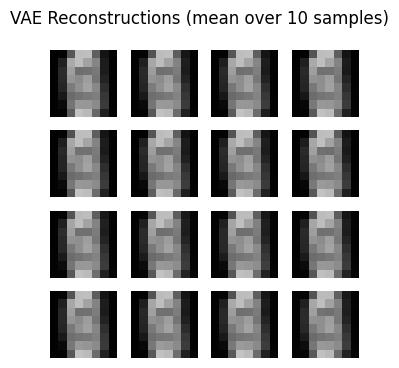

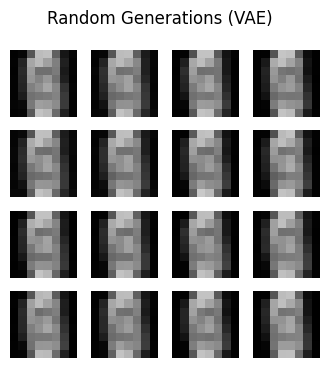

In [4]:

# Visualize reconstructions and generations

def show_images_grid(imgs, title, n=16):
    n = min(n, imgs.shape[0])
    side = int(math.sqrt(n))
    fig, axes = plt.subplots(side, side, figsize=(4,4))
    k = 0
    for i in range(side):
        for j in range(side):
            axes[i,j].imshow(imgs[k].reshape(8,8), cmap='gray', vmin=0, vmax=1)
            axes[i,j].axis('off')
            k += 1
    fig.suptitle(title)
    plt.show()

# Reconstructions (AE)
with torch.no_grad():
    xb = torch.tensor(flatten_img(X_test[:64]), dtype=torch.float32).to(device)
    xhat_ae = ae(xb).cpu().numpy()
show_images_grid(xb.cpu().numpy(), "Original (Test)")
show_images_grid(xhat_ae, "AE Reconstructions")

# Reconstructions (VAE, single sample)
with torch.no_grad():
    xhat_vae_single, _, _ = vae(xb)
    xhat_vae_single = xhat_vae_single.cpu().numpy()
show_images_grid(xhat_vae_single, "VAE Reconstructions (single sample)")

# Reconstructions (VAE, mean over 10 samples)
with torch.no_grad():
    xhats = []
    for _ in range(10):
        xhat, _, _ = vae(xb)
        xhats.append(xhat.cpu().numpy())
    xhat_vae_mean = np.mean(np.stack(xhats, axis=0), axis=0)
show_images_grid(xhat_vae_mean, "VAE Reconstructions (mean over 10 samples)")

# Random generations from prior
with torch.no_grad():
    z = torch.randn(64, latent_dim, device=device)
    gen = vae.decode(z).cpu().numpy()
show_images_grid(gen, "Random Generations (VAE)")


Mean per-pixel variance over 20 samples: 0.000238


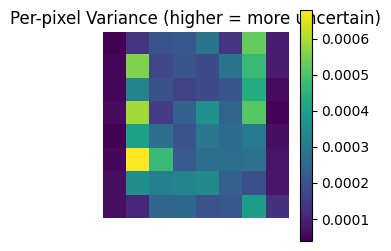

In [5]:

# Uncertainty quantification: per-pixel variance across multiple decodes for the same inputs

with torch.no_grad():
    xb = torch.tensor(flatten_img(X_test[:16]), dtype=torch.float32).to(device)
    samples = []
    T = 20
    for _ in range(T):
        xhat, _, _ = vae(xb)
        samples.append(xhat.cpu().numpy())
    samples = np.stack(samples, axis=0)  # (T, N, 64)
    var_map = samples.var(axis=0).mean(axis=0)  # mean variance per pixel across batch
    mean_var = var_map.mean()
    print(f"Mean per-pixel variance over {T} samples: {mean_var:.6f}")

# Show one example's variance heatmap
plt.figure(figsize=(3,3))
plt.imshow(var_map.reshape(8,8), cmap='viridis')
plt.title('Per-pixel Variance (higher = more uncertain)')
plt.colorbar(); plt.axis('off'); plt.show()


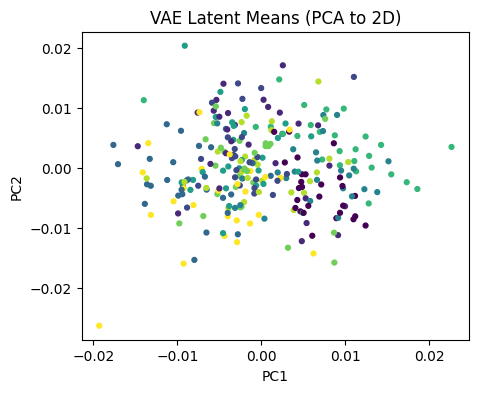

In [6]:

# Latent space visualization (mean μ) via 2D projection (PCA)
from sklearn.decomposition import PCA

# Encode test set to means
vae.eval()
mus = []
with torch.no_grad():
    for (xb,) in test_loader:
        xb = xb.to(device)
        mu, logvar = vae.encode(xb)
        mus.append(mu.cpu().numpy())
mus = np.concatenate(mus, axis=0)

pca = PCA(n_components=2, random_state=42)
Z2 = pca.fit_transform(mus)

plt.figure(figsize=(5,4))
scatter = plt.scatter(Z2[:,0], Z2[:,1], c=y_test, s=12)
plt.title("VAE Latent Means (PCA to 2D)")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.show()
